# Transfer Learning using ResNet50

In [20]:
import os
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

In [2]:
TRAINING_DIR = 'data/training/'
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rotation_range=30,
                                  zoom_range=0.4,
                                  horizontal_flip=True)

In [3]:
img_width = 128; img_height=128
batch_size = 64

In [4]:
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                   batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width)
                                                    )

Found 60646 images belonging to 15 classes.


In [5]:
VALIDATION_DIR = 'data/validation/'
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                   batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))

Found 6738 images belonging to 15 classes.


In [6]:
callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
best_model_file = 'data/resnet50_drop_batch_best_weights_256.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_accuracy', verbose=1, save_best_only=True)

In [8]:
# Set pretrained weight
#wp = 'data/resnet101_weights_tf.h5'
# Build base model
resnet50_base = ResNet50(include_top=False, weights='imagenet',
                          input_tensor=None, input_shape= (img_height, img_width, 3))

94773248/94765736 [==============================] - 9s 0us/step


In [15]:
print('Adding new layers...')
output = resnet50_base.get_layer(index= -1).output
output = Flatten()(output)
output = Dense(1024, activation = 'relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(1024, activation = 'relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(15, activation='softmax')(output)
print('New layers added!')

Adding new layers...
New layers added!


In [16]:
resnet50_model = Model(resnet50_base.input, output)
for layer in resnet50_model.layers[:20]:
    layer.trainable = False
    
resnet50_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [21]:
resnet50_model.compile(optimizer= SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = resnet50_model.fit_generator(train_generator, epochs=50, verbose=1, 
                                       validation_data = validation_generator,
                                       callbacks = [callbacks, best_model])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 948 steps, validate for 106 steps
Epoch 1/50
947/948 [============================>.] - ETA: 2s - loss: 2.3693 - accuracy: 0.3189
Epoch 00001: val_accuracy did not improve from 0.59454
948/948 [==============================] - 2675s 3s/step - loss: 2.3689 - accuracy: 0.3190 - val_loss: 1.9079 - val_accuracy: 0.4982
Epoch 2/50
947/948 [============================>.] - ETA: 2s - loss: 1.8743 - accuracy: 0.4306
Epoch 00002: val_accuracy did not improve from 0.59454
948/948 [==============================] - 2215s 2s/step - loss: 1.8748 - accuracy: 0.4304 - val_loss: 1.7541 - val_accuracy: 0.5178
Epoch 3/50
947/948 [============================>.] - ETA: 2s - loss: 1.7448 - accuracy: 0.4603
Epoch 00003: val_accuracy did not improve from 0.59454
948/948 [==============================] - 2213s 2s/step - loss: 1.7446 - accuracy: 0.4604 - val_loss: 1.6769 - val_accuracy: 0.5361
Epoch 4/50
947/948 [============================>.] - 

947/948 [============================>.] - ETA: 1s - loss: 1.2093 - accuracy: 0.5914
Epoch 00029: val_accuracy improved from 0.59454 to 0.59469, saving model to data/resnet50_drop_batch_best_weights_256.h5
948/948 [==============================] - 1473s 2s/step - loss: 1.2094 - accuracy: 0.5914 - val_loss: 1.3070 - val_accuracy: 0.5947
Epoch 30/50
947/948 [============================>.] - ETA: 1s - loss: 1.2066 - accuracy: 0.5929
Epoch 00030: val_accuracy did not improve from 0.59469
948/948 [==============================] - 1472s 2s/step - loss: 1.2066 - accuracy: 0.5929 - val_loss: 1.3074 - val_accuracy: 0.5947
Epoch 31/50
947/948 [============================>.] - ETA: 1s - loss: 1.1956 - accuracy: 0.5951
Epoch 00031: val_accuracy improved from 0.59469 to 0.59780, saving model to data/resnet50_drop_batch_best_weights_256.h5
948/948 [==============================] - 1476s 2s/step - loss: 1.1957 - accuracy: 0.5950 - val_loss: 1.2867 - val_accuracy: 0.5978
Epoch 32/50
947/948 [====

In [24]:
target_dir = 'data'
if not os.path.exists(target_dir):
    os.mkdir(target_dir)

resnet50_model.save(target_dir + 'resnet50_model.h5')
resnet50_model.save_weights(target_dir + 'resnet50_weights.h5')

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

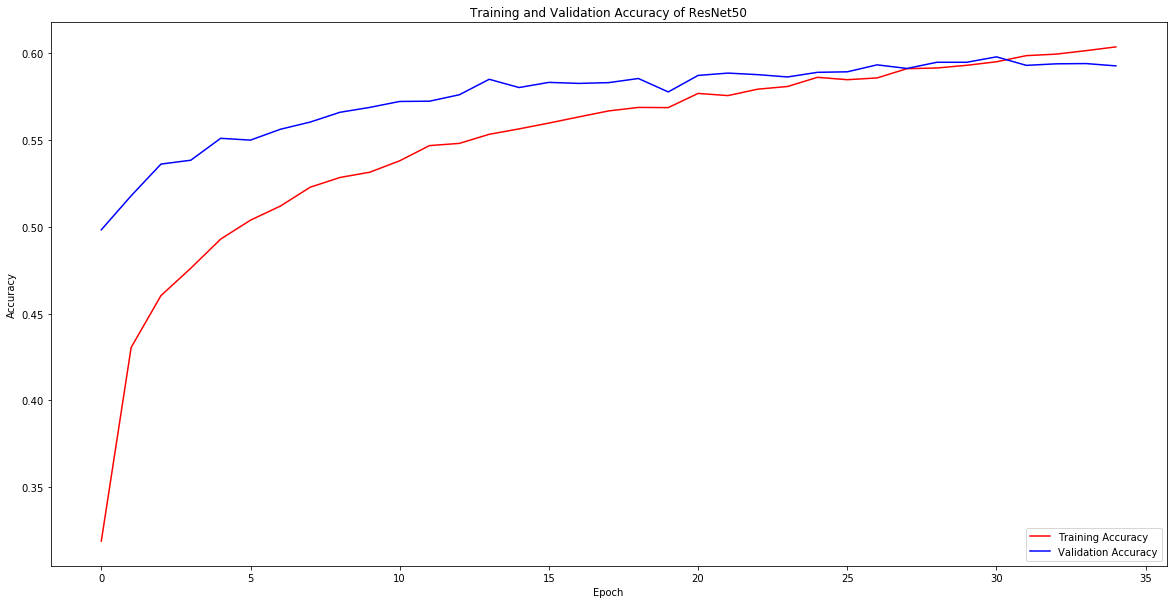

In [25]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of ResNet50')
plt.legend(loc='lower right')
plt.show()
fig.savefig('data/Accuracy_curve_resnet50_drop_batch_256.jpg')

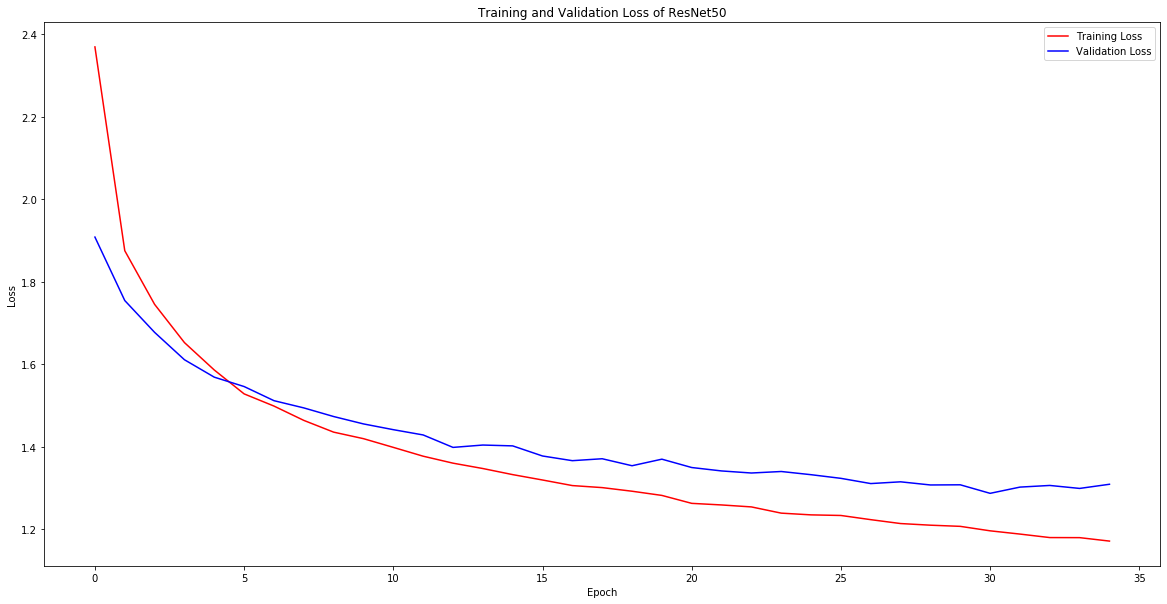

In [26]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of ResNet50')
plt.legend(loc='upper right')
plt.show()
fig.savefig('data/Loss_curve_resnet50_drop_batch_256.jpg')